# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_2108841/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_2108841/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_2108841/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


[I 2025-11-08 12:04:38,718] A new study created in RDB with name: no-name-a8b148e2-9fd8-460a-ae56-6d0d157d9432
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<12:44,  2.62it/s]

current_loss: tensor(1.4438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.452554702758789
current_loss: tensor(1.4388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<05:08,  6.47it/s]

current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4250954389572144
current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4250277280807495
current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4248067140579224
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:48, 11.86it/s]

current_loss: tensor(1.4032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4244102239608765
current_loss: tensor(1.4032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4236702919006348
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4236538410186768
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4236453771591187
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:12, 15.01it/s]

current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4236379861831665
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4237356185913086
current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4237507581710815
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:59, 11.05it/s]


current_loss_val:  1.4237538576126099
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.423811912536621
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4237924814224243
Early Stop at iteration 13 with minimal loss tensor(1.4236, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<03:45,  8.87it/s]

current_loss: tensor(1.4018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3836188316345215
current_loss: tensor(1.3697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.319787621498108
current_loss: 

  0%|          | 3/2000 [00:00<03:51,  8.62it/s]

tensor(1.3264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3052512407302856
current_loss: tensor(1.3131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3054, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:25,  9.71it/s]

current_loss_val:  1.3005752563476562
current_loss: tensor(1.3054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2959985733032227
current_loss: tensor(1.3006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2927082777023315


  0%|          | 8/2000 [00:00<03:19,  9.97it/s]

current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2892519235610962
current_loss: tensor(1.2942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2857471704483032
current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:20,  9.95it/s]

current_loss: tensor(1.2867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2810053825378418
current_loss: tensor(1.2867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2785738706588745
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:14, 10.23it/s]

current_loss_val:  1.2778934240341187
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2765476703643799
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2755576372146606


  1%|          | 15/2000 [00:01<03:15, 10.16it/s]

current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2753649950027466
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2751997709274292
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2750154733657837
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:21,  9.84it/s]

current_loss_val:  1.2751137018203735
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2752456665039062
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275526523590088


  1%|          | 20/2000 [00:02<03:31,  9.35it/s]


current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2757899761199951
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2756205797195435
Early Stop at iteration 20 with minimal loss tensor(1.2750, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:04:46,510] Trial 0 finished with value: -2.5500307083129883 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.498066550950124, 'penalty_decorrelation_ridge_second_difference': 15.558991004139429}. Best is trial 0 with value: -2.5500307083129883.
  0%|          | 1/2000 [00:00<04:18,  7.73it/s]

current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749485969543457
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:26,  9.64it/s]

current_loss_val:  1.2748662233352661
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2744730710983276
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2739708423614502


  0%|          | 5/2000 [00:00<03:26,  9.67it/s]

current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272782564163208
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718576192855835
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:23,  9.77it/s]

current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716302871704102
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271131992340088
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:23,  9.78it/s]

current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705159187316895
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27022123336792
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:21,  9.85it/s]

current_loss_val:  1.2698410749435425
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692224979400635
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:23,  9.75it/s]

current_loss_val:  1.267217993736267
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671501636505127
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:34,  9.26it/s]

current_loss_val:  1.267154335975647
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672431468963623
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<04:20,  7.62it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672942876815796
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:27,  7.40it/s]

current_loss_val:  1.2672303915023804
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670232057571411
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:38,  7.10it/s]

current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665703296661377
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660799026489258


  1%|          | 23/2000 [00:02<03:56,  8.35it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265665888786316
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265222191810608
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:47,  8.68it/s]

current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650254964828491
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2649058103561401
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<03:43,  8.82it/s]

current_loss_val:  1.2645046710968018
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643201351165771
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:28,  9.46it/s]

current_loss_val:  1.264222502708435
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631118297576904
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620471715927124


  2%|▏         | 32/2000 [00:03<03:19,  9.84it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619668245315552
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261885643005371
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:15, 10.04it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261832356452942
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261746883392334
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:28,  9.42it/s]

current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617400884628296
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261712670326233
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:16,  9.97it/s]

current_loss_val:  1.2615671157836914
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261351466178894
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612154483795166


  2%|▏         | 41/2000 [00:04<03:16,  9.95it/s]

current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611559629440308
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610622644424438
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:18,  9.89it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609094381332397
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260895848274231
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:10, 10.25it/s]

current_loss_val:  1.2608836889266968
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608052492141724
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606757879257202


  2%|▏         | 48/2000 [00:05<03:10, 10.26it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605396509170532
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260504126548767
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:05<03:13, 10.08it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604867219924927
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26040518283844
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:05<03:14, 10.03it/s]

current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602944374084473
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600083351135254
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:05<03:15,  9.94it/s]

current_loss_val:  1.2595220804214478
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2592169046401978
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2590967416763306


  3%|▎         | 56/2000 [00:05<03:16,  9.92it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587482929229736
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258456826210022
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:06<03:14, 10.01it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584623098373413
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584905624389648
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:06<03:11, 10.16it/s]

current_loss_val:  1.2585618495941162
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258661150932312
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:06<03:29,  9.27it/s]

current_loss_val:  1.258717656135559
Early Stop at iteration 61 with minimal loss tensor(1.2585, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-08 12:04:53,922] Trial 1 finished with value: -2.516913652420044 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.61776232972597, 'penalty_decorrelation_ridge_second_difference': 29.452801392493082}. Best is trial 1 with value: -2.516913652420044.
  0%|          | 1/2000 [00:00<04:18,  7.73it/s]

current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274967074394226
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749050855636597


  0%|          | 3/2000 [00:00<03:26,  9.66it/s]

current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2746622562408447
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743114233016968
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:18, 10.06it/s]

current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737029790878296
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736225128173828
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:15, 10.21it/s]

current_loss_val:  1.2735764980316162
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732439041137695
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730588912963867


  1%|          | 11/2000 [00:01<03:16, 10.12it/s]

current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730412483215332
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729843854904175
current_loss: 

  1%|          | 13/2000 [00:01<03:17, 10.08it/s]

tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2728582620620728
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725626230239868
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:16, 10.11it/s]

current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725157737731934
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724387645721436
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:16, 10.10it/s]

current_loss_val:  1.2723486423492432
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714884281158447
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:24,  9.68it/s]

current_loss_val:  1.2707425355911255
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702488899230957
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672923803329468


  1%|          | 21/2000 [00:02<03:35,  9.18it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667697668075562
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266616702079773


  1%|          | 23/2000 [00:02<03:24,  9.66it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653101682662964
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629255056381226
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:18,  9.96it/s]

current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610684633255005
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260138750076294
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:15, 10.09it/s]

current_loss_val:  1.259799838066101
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258452296257019
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:19,  9.85it/s]

current_loss_val:  1.2583750486373901
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583423852920532
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258237361907959


  2%|▏         | 33/2000 [00:03<03:15, 10.05it/s]

current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583222389221191
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582907676696777
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:16,  9.98it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258276104927063
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583850622177124
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 35/2000 [00:03<03:24,  9.62it/s]


tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2585124969482422
Early Stop at iteration 35 with minimal loss tensor(1.2582, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:04:58,512] Trial 2 finished with value: -2.516474962234497 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.634991745049366, 'penalty_decorrelation_ridge_second_difference': 20.900911571742938}. Best is trial 2 with value: -2.516474962234497.
  0%|          | 1/2000 [00:00<04:07,  8.08it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2750458717346191
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275052785873413


  0%|          | 3/2000 [00:00<03:20,  9.98it/s]

current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2750732898712158
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2751065492630005
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:57,  8.41it/s]

current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2753186225891113
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2754327058792114
Early Stop at iteration 5 with minimal loss tensor(1.2750, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-08 12:05:00,855] Trial 3 finished with value: -2.550091505050659 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.56271034061251, 'penalty_decorrelation_ridge_second_difference': 27.31057531490005}. Best is trial 2 with value: -2.516474962234497.
  0%|          | 2/2000 [00:00<02:59, 11.12it/s]

current_loss: tensor(1.2753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749569416046143
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2752619981765747
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:33,  9.34it/s]

current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2755829095840454
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275741457939148
current_loss: 

  0%|          | 5/2000 [00:00<04:01,  8.27it/s]


tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276227355003357
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2759654521942139
Early Stop at iteration 5 with minimal loss tensor(1.2750, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:05:02,675] Trial 4 finished with value: -2.5499141216278076 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.08481814000356, 'penalty_decorrelation_ridge_second_difference': 2.261552825353957}. Best is trial 2 with value: -2.516474962234497.
  0%|          | 1/2000 [00:00<04:14,  7.86it/s]

current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749868631362915
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274942398071289


  0%|          | 4/2000 [00:00<03:24,  9.76it/s]

current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2747690677642822
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745213508605957
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:12, 10.35it/s]

current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741354703903198
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740986347198486
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:08, 10.57it/s]

current_loss_val:  1.2740610837936401
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737619876861572
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735871076583862


  0%|          | 10/2000 [00:00<03:05, 10.72it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735662460327148
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735040187835693
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:03, 10.83it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733614444732666
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273041009902954
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:18, 10.02it/s]

current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729817628860474
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2728790044784546
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:16, 10.11it/s]

current_loss_val:  1.2727609872817993
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716618776321411
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:22,  9.77it/s]

current_loss_val:  1.270894169807434
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704025506973267
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674566507339478


  1%|          | 21/2000 [00:02<03:26,  9.59it/s]

current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266945719718933
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266831398010254


  1%|          | 23/2000 [00:02<03:18,  9.96it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661001682281494
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646268606185913
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:13, 10.18it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261947512626648
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611209154129028
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:06, 10.58it/s]

current_loss_val:  1.261008381843567
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260811448097229
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260656476020813


  2%|▏         | 31/2000 [00:03<03:03, 10.71it/s]

current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603135108947754
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603225708007812
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:02, 10.80it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603400945663452
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603645324707031
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:16, 10.03it/s]


current_loss_val:  1.2604621648788452
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605993747711182
Early Stop at iteration 34 with minimal loss tensor(1.2603, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:05:07,569] Trial 5 finished with value: -2.52062726020813 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.462039606641007, 'penalty_decorrelation_ridge_second_difference': 21.736760133205813}. Best is trial 2 with value: -2.516474962234497.
  0%|          | 2/2000 [00:00<02:58, 11.20it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741063833236694
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272889494895935
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:01, 11.01it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696267366409302
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695508003234863
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:06, 10.66it/s]

current_loss_val:  1.2694133520126343
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269264578819275
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691761255264282


  0%|          | 8/2000 [00:00<03:10, 10.48it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688449621200562
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687735557556152
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:11, 10.38it/s]

current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268389105796814
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267188310623169


  1%|          | 12/2000 [00:01<04:25,  7.49it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667285203933716
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662487030029297
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:56,  8.38it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643073797225952
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264005422592163
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:50,  8.62it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264024019241333
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634782791137695
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:27,  9.56it/s]

current_loss_val:  1.263437032699585
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631083726882935
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263001561164856


  1%|          | 21/2000 [00:02<03:19,  9.92it/s]

current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630130052566528
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627933025360107
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:14, 10.16it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626651525497437
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262107014656067
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:06, 10.56it/s]

current_loss_val:  1.261317491531372
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614234685897827
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261448860168457


  1%|▏         | 29/2000 [00:03<03:14, 10.15it/s]

current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261361837387085
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261393666267395


  2%|▏         | 31/2000 [00:03<03:08, 10.43it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612837553024292
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613385915756226
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:13, 10.16it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614067792892456
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261378526687622
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:09, 10.39it/s]

current_loss_val:  1.2611145973205566
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611660957336426
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261197566986084


  2%|▏         | 37/2000 [00:03<03:07, 10.45it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611085176467896
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606594562530518
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<03:06, 10.49it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605271339416504
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602989673614502
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:04, 10.64it/s]

current_loss_val:  1.259302020072937
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258452296257019
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:08, 10.40it/s]

current_loss_val:  1.2583962678909302
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581253051757812
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573713064193726


  2%|▏         | 47/2000 [00:04<03:03, 10.64it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257460355758667
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256829023361206
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:04<03:12, 10.14it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567574977874756
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256825566291809
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:05<03:17,  9.89it/s]

current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568118572235107
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256709337234497
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:05<03:11, 10.18it/s]

current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567764520645142
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567538022994995
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565991878509521
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:05<04:19,  7.50it/s]

current_loss_val:  1.256546974182129
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:06<04:59,  6.48it/s]

current_loss_val:  1.2564165592193604
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  3%|▎         | 57/2000 [00:06<06:51,  4.72it/s]

tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560633420944214
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:06<08:29,  3.81it/s]

current_loss_val:  1.255893588066101
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:07<08:32,  3.79it/s]

current_loss_val:  1.2555428743362427
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:07<11:06,  2.91it/s]

current_loss_val:  1.255515456199646
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:07<10:25,  3.10it/s]

current_loss_val:  1.2553843259811401
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:08<11:53,  2.72it/s]

current_loss_val:  1.2551970481872559
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:09<15:14,  2.12it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255136489868164
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:09<15:31,  2.08it/s]

current_loss_val:  1.2550791501998901
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:09<13:33,  2.38it/s]

current_loss_val:  1.255203366279602
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:10<12:54,  2.50it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548748254776
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:10<12:18,  2.62it/s]

current_loss_val:  1.2549705505371094
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:11<11:57,  2.69it/s]

current_loss_val:  1.2549834251403809
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:11<11:26,  2.81it/s]

current_loss_val:  1.254983901977539
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:11<11:11,  2.87it/s]

current_loss_val:  1.254797339439392
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:11<10:48,  2.97it/s]

current_loss_val:  1.254919171333313
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:12<10:26,  3.08it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549195289611816
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:12<09:53,  3.25it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548675537109375
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:12<09:20,  3.44it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549282312393188
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:13<05:38,  5.69it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548604011535645
Early Stop at iteration 74 with minimal loss tensor(1.2548, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-08 12:05:22,100] Trial 6 finished with value: -2.509594440460205 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.3221504993302373, 'penalty_decorrelation_ridge_second_difference': 11.723372043513846}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 1/2000 [00:00<03:57,  8.41it/s]

current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2747902870178223
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745693922042847


  0%|          | 3/2000 [00:00<03:17, 10.12it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734624147415161
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720850706100464
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:11, 10.43it/s]

current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699215412139893
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693992853164673
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:06, 10.66it/s]

current_loss_val:  1.2692681550979614
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268534541130066
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680708169937134


  1%|          | 11/2000 [00:01<03:06, 10.69it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268033742904663
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26797616481781
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:16, 10.12it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677783966064453
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267492651939392
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:12, 10.33it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267410159111023
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669376134872437
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:11, 10.37it/s]

current_loss_val:  1.266616702079773
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665176391601562
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2663973569869995


  1%|          | 19/2000 [00:01<03:08, 10.52it/s]

current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661727666854858
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659446001052856


  1%|          | 21/2000 [00:02<03:16, 10.08it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657454013824463
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652559280395508
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:23,  9.70it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651199102401733
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650477886199951
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:17,  9.99it/s]

current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264449954032898
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640794515609741
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:12, 10.22it/s]

current_loss_val:  1.2636082172393799
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262882113456726
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:13, 10.17it/s]

current_loss_val:  1.2624294757843018
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603435516357422
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593059539794922


  2%|▏         | 33/2000 [00:03<03:11, 10.29it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2595607042312622
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596584558486938
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:16, 10.01it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599577903747559
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260140299797058
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:18,  9.90it/s]


current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602667808532715
Early Stop at iteration 35 with minimal loss tensor(1.2593, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:05:26,744] Trial 7 finished with value: -2.5186116695404053 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.904080247767862, 'penalty_decorrelation_ridge_second_difference': 20.393201343503403}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<02:55, 11.41it/s]

current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2742080688476562
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729415893554688
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:58, 11.20it/s]

current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270331621170044
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700860500335693
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:04, 10.79it/s]

current_loss_val:  1.270047903060913
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697527408599854
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696975469589233


  0%|          | 8/2000 [00:00<03:05, 10.72it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695186138153076
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690757513046265
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:06, 10.66it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2673345804214478
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666902542114258
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:04, 10.76it/s]

current_loss_val:  1.2662783861160278
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657158374786377
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651842832565308


  1%|          | 16/2000 [00:01<03:02, 10.84it/s]

current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642908096313477
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2645490169525146
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:05, 10.69it/s]

current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644109725952148
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642996311187744
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:04, 10.70it/s]

current_loss_val:  1.2642745971679688
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641040086746216
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639081478118896


  1%|          | 22/2000 [00:02<03:05, 10.69it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263290286064148
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620511054992676
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:04, 10.69it/s]

current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618354558944702
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618743181228638
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:03, 10.77it/s]

current_loss_val:  1.2616915702819824
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612769603729248
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:09, 10.40it/s]

current_loss_val:  1.2611833810806274
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260491967201233
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598170042037964


  2%|▏         | 32/2000 [00:03<03:15, 10.08it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596436738967896
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2589868307113647


  2%|▏         | 34/2000 [00:03<03:08, 10.42it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583144903182983
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577534914016724
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:08, 10.43it/s]

current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570809125900269
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256829857826233
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:08, 10.42it/s]

current_loss_val:  1.256648302078247
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562735080718994
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561848163604736


  2%|▏         | 40/2000 [00:03<03:06, 10.50it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558979988098145
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557600736618042
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<03:13, 10.14it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255869746208191
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558132410049438
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:10, 10.29it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557356357574463
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255783200263977
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:17,  9.87it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556736469268799
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255686640739441
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:04<03:12, 10.15it/s]

current_loss_val:  1.255753993988037
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559185028076172
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<03:12, 10.14it/s]

current_loss_val:  1.2558050155639648
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554161548614502
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552909851074219


  3%|▎         | 54/2000 [00:05<03:16,  9.88it/s]

current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2550195455551147
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255020260810852


  3%|▎         | 56/2000 [00:05<03:11, 10.15it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254996657371521
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.254858136177063
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:05<03:08, 10.30it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552293539047241
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549713850021362
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:05<03:06, 10.41it/s]

current_loss_val:  1.2549364566802979
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549980878829956
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:05<03:10, 10.19it/s]


current_loss_val:  1.2548844814300537
Early Stop at iteration 60 with minimal loss tensor(1.2549, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:05:33,997] Trial 8 finished with value: -2.509716033935547 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.910363639418493, 'penalty_decorrelation_ridge_second_difference': 9.287081029444979}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<02:58, 11.18it/s]

current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2747173309326172
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2744888067245483
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:00, 11.05it/s]

current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273871660232544
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735857963562012
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:07, 10.64it/s]

current_loss_val:  1.2728937864303589
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2728089094161987
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725340127944946


  0%|          | 8/2000 [00:00<03:06, 10.66it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720539569854736
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271666407585144
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:06, 10.65it/s]

current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711139917373657
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691890001296997
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:16, 10.09it/s]

current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677024602890015
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658772468566895
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:09, 10.47it/s]

current_loss_val:  1.2652454376220703
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640373706817627
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624009847640991


  1%|          | 18/2000 [00:01<03:06, 10.62it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617923021316528
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614847421646118
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:05, 10.65it/s]

current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26144278049469
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2615642547607422
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:15, 10.12it/s]

current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619529962539673
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619081735610962
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:17, 10.01it/s]


current_loss_val:  1.2620657682418823
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625635862350464
Early Stop at iteration 23 with minimal loss tensor(1.2614, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:05:37,511] Trial 9 finished with value: -2.522885322570801 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.092976627839672, 'penalty_decorrelation_ridge_second_difference': 8.705322867219934}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<03:01, 11.01it/s]

current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2746282815933228
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2742061614990234
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:01, 10.97it/s]

current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732421159744263
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272741436958313
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:04, 10.82it/s]

current_loss_val:  1.2724429368972778
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716983556747437
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717134952545166


  0%|          | 8/2000 [00:00<03:05, 10.74it/s]

current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712979316711426
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710765600204468
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:04, 10.77it/s]

current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270734190940857
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705806493759155
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:16, 10.14it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701016664505005
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677451372146606
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:23,  9.75it/s]

current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267163634300232
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668075561523438
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:13, 10.23it/s]

current_loss_val:  1.2651453018188477
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2638431787490845
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634565830230713


  1%|          | 20/2000 [00:01<03:10, 10.38it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263337254524231
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626968622207642
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:09, 10.47it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613688707351685
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607884407043457
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:09, 10.42it/s]

current_loss_val:  1.2605043649673462
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593750953674316
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<04:08,  7.96it/s]

current_loss_val:  1.2594016790390015
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2589949369430542


  1%|▏         | 28/2000 [00:02<03:57,  8.32it/s]

current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2585678100585938
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584164142608643


  2%|▏         | 30/2000 [00:03<03:40,  8.93it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584644556045532
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258701205253601
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:36,  9.09it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2588714361190796
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586274147033691
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:28,  9.46it/s]


current_loss_val:  1.258590579032898
Early Stop at iteration 32 with minimal loss tensor(1.2584, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:05:41,645] Trial 10 finished with value: -2.5168328285217285 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.645584634587692, 'penalty_decorrelation_ridge_second_difference': 7.392696169670156}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<02:58, 11.22it/s]

current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741897106170654
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720606327056885
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:00, 11.07it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701826095581055
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702183723449707
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:02, 10.95it/s]

current_loss_val:  1.2704282999038696
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2703837156295776
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704070806503296


  0%|          | 7/2000 [00:00<03:28,  9.54it/s]


current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704025506973267
Early Stop at iteration 7 with minimal loss tensor(1.2702, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:05:43,707] Trial 11 finished with value: -2.540364980697632 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.515393565084718, 'penalty_decorrelation_ridge_second_difference': 4.531661120053698}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 1/2000 [00:00<04:02,  8.23it/s]

current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274997353553772
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749613523483276


  0%|          | 3/2000 [00:00<03:22,  9.85it/s]

current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748137712478638
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2746011018753052
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:16, 10.13it/s]

current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274232029914856
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274192452430725
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:10, 10.47it/s]

current_loss_val:  1.2741570472717285
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2738877534866333
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736892700195312


  1%|          | 11/2000 [00:01<03:07, 10.58it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736804485321045
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736250162124634
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:06, 10.65it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273459553718567
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273081660270691
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:08, 10.53it/s]

current_loss_val:  1.2730575799942017
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730164527893066
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729429006576538


  1%|          | 17/2000 [00:01<03:08, 10.54it/s]

current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724109888076782
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719873189926147
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:09, 10.45it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708806991577148
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665746212005615
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:05, 10.67it/s]

current_loss_val:  1.2666128873825073
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666367292404175
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668136358261108


  1%|          | 24/2000 [00:02<03:16, 10.08it/s]


current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670629024505615
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670940160751343
Early Stop at iteration 24 with minimal loss tensor(1.2666, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:05:47,406] Trial 12 finished with value: -2.533149242401123 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.214469723876313, 'penalty_decorrelation_ridge_second_difference': 23.654433532912083}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<02:56, 11.30it/s]

current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741718292236328
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737410068511963
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.26it/s]

current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272270679473877
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706520557403564
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:22,  9.84it/s]

current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26917564868927
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683435678482056
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.11it/s]

current_loss_val:  1.2680593729019165
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267379641532898
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668113708496094


  0%|          | 10/2000 [00:00<03:13, 10.27it/s]

current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662464380264282
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661677598953247
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:10, 10.46it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660614252090454
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656289339065552
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:21,  9.85it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654492855072021
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654731273651123
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:13, 10.25it/s]

current_loss_val:  1.2653484344482422
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652993202209473
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264819860458374


  1%|          | 20/2000 [00:01<03:09, 10.45it/s]

current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264719843864441
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644257545471191
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:07, 10.53it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624582052230835
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604917287826538
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:07, 10.55it/s]

current_loss_val:  1.2594008445739746
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259057879447937
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586760520935059


  1%|▏         | 26/2000 [00:02<03:07, 10.53it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257533311843872
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575457096099854
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:04, 10.71it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256952166557312
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256906270980835
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:01, 10.84it/s]

current_loss_val:  1.2570176124572754
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573487758636475
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257285475730896


  2%|▏         | 33/2000 [00:03<03:13, 10.15it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572914361953735
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257300853729248
Early Stop at iteration 33 with minimal loss tensor(1.2569, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-08 12:05:51,877] Trial 13 finished with value: -2.51381254196167 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.5097285184781417, 'penalty_decorrelation_ridge_second_difference': 15.053034096133553}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 1/2000 [00:00<04:16,  7.78it/s]

current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749851942062378
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749388217926025


  0%|          | 3/2000 [00:00<03:25,  9.71it/s]

current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274756908416748
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2744957208633423
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:17, 10.10it/s]

current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740681171417236
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740223407745361
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:19,  9.97it/s]

current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2739834785461426
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736780643463135
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:14, 10.23it/s]

current_loss_val:  1.2735031843185425
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734826803207397
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734205722808838


  1%|          | 12/2000 [00:01<03:12, 10.33it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732750177383423
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729514837265015
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:12, 10.30it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272887945175171
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272773265838623
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:07, 10.58it/s]

current_loss_val:  1.2726377248764038
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714085578918457
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:13, 10.25it/s]

current_loss_val:  1.2706665992736816
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702109813690186
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677857875823975
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<04:15,  7.74it/s]

current_loss_val:  1.26683509349823
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267091155052185
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671843767166138


  1%|▏         | 25/2000 [00:02<03:56,  8.37it/s]

current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674882411956787
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678776979446411


  1%|▏         | 25/2000 [00:02<03:39,  9.00it/s]


current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680765390396118
Early Stop at iteration 25 with minimal loss tensor(1.2668, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:05:55,436] Trial 14 finished with value: -2.533670425415039 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.256838038811193, 'penalty_decorrelation_ridge_second_difference': 21.884929211706275}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<03:32,  9.38it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2739334106445312
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715439796447754


  0%|          | 4/2000 [00:00<03:17, 10.11it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690668106079102
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690783739089966
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:13, 10.30it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691787481307983
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691584825515747
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:41,  8.98it/s]


current_loss_val:  1.2691017389297485
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691344022750854
Early Stop at iteration 7 with minimal loss tensor(1.2691, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:05:56,949] Trial 15 finished with value: -2.5381336212158203 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3950568061557818, 'penalty_decorrelation_ridge_second_difference': 3.689236416106114}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<02:59, 11.12it/s]

current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2744362354278564
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741225957870483
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:59, 11.15it/s]

current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731900215148926
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720203399658203
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:06, 10.71it/s]

current_loss_val:  1.2695642709732056
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697644233703613
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695544958114624


  0%|          | 8/2000 [00:00<03:04, 10.78it/s]

current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694973945617676
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695698738098145
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:04, 10.81it/s]

current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695202827453613
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694430351257324
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:03, 10.83it/s]

current_loss_val:  1.2690867185592651
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688612937927246
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26853346824646


  1%|          | 16/2000 [00:01<03:03, 10.80it/s]

current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267006516456604
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650357484817505
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:05, 10.69it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639726400375366
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625985145568848
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:06, 10.63it/s]

current_loss_val:  1.2591898441314697
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582063674926758
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258413314819336


  1%|          | 22/2000 [00:02<03:05, 10.65it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584574222564697
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584351301193237
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:11, 10.30it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586442232131958
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2585684061050415
Early Stop at iteration 24 with minimal loss tensor(1.2582, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-08 12:06:00,216] Trial 16 finished with value: -2.5164124965667725 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.404982865816024, 'penalty_decorrelation_ridge_second_difference': 11.58406343636392}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<03:00, 11.08it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741379737854004
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272873878479004
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:04, 10.80it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698339223861694
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697135210037231
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:02, 10.94it/s]

current_loss_val:  1.269614338874817
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694454193115234
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693679332733154


  0%|          | 8/2000 [00:00<03:05, 10.73it/s]

current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269039273262024
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2689299583435059
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:06, 10.65it/s]

current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268640398979187
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672665119171143
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:06, 10.63it/s]

current_loss_val:  1.2668848037719727
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665516138076782
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641456127166748


  1%|          | 16/2000 [00:01<03:05, 10.71it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636202573776245
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629365921020508


  1%|          | 18/2000 [00:01<03:57,  8.36it/s]

current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624778747558594
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262130618095398


  1%|          | 20/2000 [00:02<03:38,  9.05it/s]

current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261597752571106
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260894536972046
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:27,  9.54it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593364715576172
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593178749084473
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:20,  9.83it/s]

current_loss_val:  1.2593289613723755
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2589038610458374
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2588779926300049


  1%|▏         | 26/2000 [00:02<03:13, 10.19it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584986686706543
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582100629806519
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:25,  9.61it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2579880952835083
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258078932762146
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:17,  9.97it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2579482793807983
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577850818634033
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:12, 10.21it/s]

current_loss_val:  1.257607102394104
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572605609893799
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257340431213379


  2%|▏         | 36/2000 [00:03<03:05, 10.60it/s]

current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573379278182983
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569661140441895
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:05, 10.56it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569880485534668
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568731307983398
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:05, 10.56it/s]

current_loss_val:  1.2565162181854248
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564822435379028
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563687562942505


  2%|▏         | 42/2000 [00:04<03:06, 10.49it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560468912124634
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555103302001953
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:05, 10.56it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555742263793945
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255359172821045
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:04<03:05, 10.52it/s]

current_loss_val:  1.2553291320800781
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554240226745605
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555689811706543


  2%|▎         | 50/2000 [00:04<03:04, 10.56it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255454659461975
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554619312286377
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:04<03:14, 10.03it/s]


current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558718919754028
Early Stop at iteration 50 with minimal loss tensor(1.2553, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:06,180] Trial 17 finished with value: -2.510658025741577 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.514821458673174, 'penalty_decorrelation_ridge_second_difference': 10.808323984561358}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 1/2000 [00:00<04:13,  7.90it/s]

current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2747691869735718
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745258808135986


  0%|          | 3/2000 [00:00<03:23,  9.80it/s]

current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273108720779419
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714651823043823
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:13, 10.33it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693321704864502
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686580419540405
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:12, 10.35it/s]

current_loss_val:  1.2684910297393799
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678741216659546
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2673611640930176


  1%|          | 11/2000 [00:01<03:07, 10.60it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671222686767578
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668484449386597
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:08, 10.54it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657815217971802
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643479108810425
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:09, 10.45it/s]

current_loss_val:  1.264121651649475
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640459537506104
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636762857437134


  1%|          | 17/2000 [00:01<03:09, 10.45it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630006074905396
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626694440841675
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:11, 10.32it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262284755706787
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613203525543213
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:08, 10.46it/s]

current_loss_val:  1.2607815265655518
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598984241485596
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587437629699707


  1%|▏         | 25/2000 [00:02<03:08, 10.48it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587286233901978
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586852312088013
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:07, 10.55it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584506273269653
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258454442024231
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:05, 10.65it/s]

current_loss_val:  1.2582935094833374
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583727836608887
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582757472991943


  2%|▏         | 31/2000 [00:02<03:07, 10.50it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583086490631104
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582979202270508
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:06, 10.53it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2579938173294067
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578352689743042
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:07, 10.48it/s]

current_loss_val:  1.2576749324798584
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575839757919312
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574114799499512


  2%|▏         | 39/2000 [00:03<03:05, 10.56it/s]

current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257218837738037
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257162094116211
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<03:06, 10.48it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569807767868042
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567437887191772
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:06, 10.49it/s]

current_loss_val:  1.256759524345398
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568061351776123
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2567424774169922


  2%|▏         | 45/2000 [00:04<03:03, 10.66it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256709098815918
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566124200820923
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<03:06, 10.45it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564915418624878
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564617395401
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:04<03:03, 10.64it/s]

current_loss_val:  1.2564157247543335
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256293773651123
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560783624649048


  3%|▎         | 53/2000 [00:05<03:04, 10.54it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559453248977661
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559387683868408
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:05<03:04, 10.52it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559350728988647
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25595223903656
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:05<03:06, 10.45it/s]

current_loss_val:  1.2560166120529175
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559832334518433
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559844255447388


  3%|▎         | 58/2000 [00:05<03:08, 10.28it/s]


current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560151815414429
Early Stop at iteration 58 with minimal loss tensor(1.2559, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:12,515] Trial 18 finished with value: -2.5118701457977295 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.793277124260552, 'penalty_decorrelation_ridge_second_difference': 23.40908247331018}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<03:05, 10.77it/s]

current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2744207382202148
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273202896118164
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:04, 10.84it/s]

current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271622657775879
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716050148010254
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:23,  9.79it/s]

current_loss_val:  1.2714029550552368
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715286016464233
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.06it/s]

current_loss_val:  1.271382451057434
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707250118255615
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700600624084473


  0%|          | 10/2000 [00:00<03:15, 10.20it/s]

current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683912515640259
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2673709392547607
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:09, 10.46it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668741941452026
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648465633392334
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:22,  9.82it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639968395233154
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636911869049072
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:08, 10.51it/s]

current_loss_val:  1.2619084119796753
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604758739471436
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594690322875977


  1%|          | 20/2000 [00:01<03:06, 10.61it/s]

current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2590597867965698
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2580811977386475
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:23,  9.71it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257182002067566
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571003437042236


  1%|          | 24/2000 [00:02<03:24,  9.66it/s]

current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571922540664673
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573833465576172


  1%|▏         | 26/2000 [00:02<03:15, 10.09it/s]

current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582100629806519
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2576498985290527
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:22,  9.76it/s]


current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575522661209106
Early Stop at iteration 26 with minimal loss tensor(1.2571, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:15,909] Trial 19 finished with value: -2.5142006874084473 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.036674133075035, 'penalty_decorrelation_ridge_second_difference': 2.28828694925447}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2744759321212769
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743806838989258
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:05, 10.78it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2742027044296265
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2738796472549438
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:16, 10.16it/s]

current_loss_val:  1.2717952728271484
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707695960998535
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:10, 10.48it/s]

current_loss_val:  1.270296573638916
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690364122390747
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268031120300293
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:04, 10.76it/s]

current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678066492080688
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674604654312134
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:59, 11.05it/s]

current_loss_val:  1.2659077644348145
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2645312547683716
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637667655944824
current_loss: 

  1%|          | 16/2000 [00:01<02:59, 11.05it/s]

tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636290788650513
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630161046981812
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:58, 11.11it/s]

current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261464238166809
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261240839958191
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:58, 11.08it/s]

current_loss_val:  1.2604084014892578
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598475217819214
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591663599014282


  1%|          | 22/2000 [00:02<03:07, 10.56it/s]

current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2585647106170654
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2583692073822021
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:06, 10.61it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258350133895874
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581751346588135
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:05, 10.63it/s]

current_loss_val:  1.2578881978988647
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2580090761184692
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2579710483551025


  2%|▏         | 30/2000 [00:02<03:03, 10.72it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2580326795578003
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25810968875885


  2%|▏         | 30/2000 [00:02<03:16, 10.02it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258095145225525
Early Stop at iteration 30 with minimal loss tensor(1.2579, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-08 12:06:19,957] Trial 20 finished with value: -2.5157761573791504 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.159811558320612, 'penalty_decorrelation_ridge_second_difference': 14.31356668152043}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<02:58, 11.18it/s]

current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741338014602661
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273105502128601
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699705362319946
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269600510597229
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:10, 10.45it/s]

current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694072723388672
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691346406936646
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:06, 10.70it/s]

current_loss_val:  1.2689539194107056
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685555219650269
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683721780776978


  0%|          | 10/2000 [00:00<03:05, 10.73it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2676008939743042
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666300535202026
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653884887695312
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646822929382324
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<05:00,  6.62it/s]

current_loss_val:  1.2637531757354736
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<06:19,  5.23it/s]

current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629036903381348
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<08:34,  3.86it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621923685073853
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:03<10:49,  3.05it/s]

current_loss_val:  1.261936068534851
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:03<12:57,  2.55it/s]

current_loss_val:  1.2608342170715332
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<14:06,  2.34it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259769320487976
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:04<10:45,  3.07it/s]

current_loss_val:  1.2597734928131104
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2590330839157104
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:04<07:27,  4.42it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2589749097824097
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591280937194824


  1%|          | 24/2000 [00:05<06:40,  4.93it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2593662738800049
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:05<05:30,  5.97it/s]

current_loss_val:  1.259113073348999
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591345310211182
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:05<06:53,  4.77it/s]


current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259270191192627
Early Stop at iteration 26 with minimal loss tensor(1.2590, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:26,456] Trial 21 finished with value: -2.5179498195648193 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.888171946087472, 'penalty_decorrelation_ridge_second_difference': 12.007034764702551}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<03:08, 10.58it/s]

current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741646766662598
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729082107543945
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:06, 10.68it/s]

current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700285911560059
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698512077331543
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:07, 10.63it/s]

current_loss_val:  1.2697744369506836
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695684432983398
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694921493530273


  0%|          | 8/2000 [00:00<03:09, 10.51it/s]

current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691748142242432
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:25,  9.66it/s]

current_loss_val:  1.2690168619155884
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2685261964797974
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672321796417236


  1%|          | 12/2000 [00:01<03:23,  9.76it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666455507278442
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666633129119873
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:17, 10.06it/s]

current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664326429367065
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265744924545288
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:26,  9.59it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655240297317505
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652510404586792
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:19,  9.94it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647533416748047
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2645193338394165
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:15, 10.10it/s]

current_loss_val:  1.2640668153762817
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639683485031128
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640293836593628


  1%|          | 23/2000 [00:02<03:23,  9.71it/s]

current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642196416854858
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264206886291504


  1%|▏         | 25/2000 [00:02<03:16, 10.03it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264169692993164
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:27,  9.51it/s]


current_loss_val:  1.2639899253845215
Early Stop at iteration 25 with minimal loss tensor(1.2640, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:30,108] Trial 22 finished with value: -2.5279364585876465 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.412858229208457, 'penalty_decorrelation_ridge_second_difference': 10.263005789774603}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<02:59, 11.13it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740315198898315
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723884582519531
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:20,  9.96it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700262069702148
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691210508346558
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:16, 10.13it/s]

current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268534779548645
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677348852157593
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:14, 10.22it/s]

current_loss_val:  1.2675923109054565
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2672778367996216
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671176195144653


  0%|          | 10/2000 [00:00<03:10, 10.44it/s]

current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678529024124146
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266641616821289
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:11, 10.38it/s]

current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664659023284912


  1%|          | 14/2000 [00:01<04:32,  7.28it/s]

current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662742137908936
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659720182418823


  1%|          | 16/2000 [00:01<04:05,  8.08it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264643907546997
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648298740386963
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:59,  8.27it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644613981246948
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643117904663086
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:31,  9.38it/s]

current_loss_val:  1.2642446756362915
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642053365707397
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263971209526062


  1%|          | 23/2000 [00:02<03:23,  9.74it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2639024257659912
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2638096809387207
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:18,  9.94it/s]

current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263414978981018
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262158751487732
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:15, 10.07it/s]

current_loss_val:  1.2621831893920898
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619776725769043
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261328935623169


  1%|▏         | 29/2000 [00:03<03:12, 10.25it/s]

current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610654830932617
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260145902633667
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:12, 10.22it/s]

current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2589143514633179
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258866548538208
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:23,  9.66it/s]

current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584595680236816
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257926344871521
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:15, 10.05it/s]

current_loss_val:  1.2577078342437744
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568544149398804
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256937026977539


  2%|▏         | 39/2000 [00:04<03:11, 10.25it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569422721862793
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563486099243164
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:07, 10.42it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564051151275635
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561650276184082
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:12, 10.16it/s]

current_loss_val:  1.2559915781021118
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562541961669922
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560733556747437


  2%|▏         | 45/2000 [00:04<03:10, 10.26it/s]

current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560017108917236
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560478448867798
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:24,  9.56it/s]


current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560230493545532
Early Stop at iteration 46 with minimal loss tensor(1.2560, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:35,834] Trial 23 finished with value: -2.5119833946228027 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.43628459086705185, 'penalty_decorrelation_ridge_second_difference': 11.701274092727061}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<03:38,  9.14it/s]

current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740243673324585
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271745204925537


  0%|          | 4/2000 [00:00<03:18, 10.05it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692725658416748
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695081233978271
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:16, 10.15it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696094512939453
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698432207107544
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:39,  9.06it/s]


current_loss_val:  1.2697309255599976
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697441577911377
Early Stop at iteration 7 with minimal loss tensor(1.2693, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:37,230] Trial 24 finished with value: -2.5385448932647705 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.192063830833808, 'penalty_decorrelation_ridge_second_difference': 0.3318115541455047}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<03:01, 11.04it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743333578109741
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730813026428223
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:03, 10.85it/s]

current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271140217781067
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708967924118042
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:02, 10.94it/s]

current_loss_val:  1.2709403038024902
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2706542015075684
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:13, 10.29it/s]

current_loss_val:  1.2704166173934937
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701643705368042
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692369222640991


  0%|          | 10/2000 [00:00<03:08, 10.56it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268637776374817
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674721479415894
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:12, 10.35it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2653424739837646
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631871700286865
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:09, 10.45it/s]

current_loss_val:  1.26298189163208
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263108253479004
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631646394729614


  1%|          | 18/2000 [00:01<03:05, 10.70it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263150691986084
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263534426689148
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:19,  9.91it/s]


current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263317584991455
Early Stop at iteration 18 with minimal loss tensor(1.2630, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:39,674] Trial 25 finished with value: -2.525963544845581 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.04074687013641, 'penalty_decorrelation_ridge_second_difference': 6.758902819121985}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 2/2000 [00:00<02:59, 11.14it/s]

current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741533517837524
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740802764892578
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:04, 10.84it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2738935947418213
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735413312911987
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:20,  9.96it/s]

current_loss_val:  1.2712739706039429
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690845727920532
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:17, 10.10it/s]

current_loss_val:  1.2683719396591187
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267869472503662
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674213647842407


  0%|          | 10/2000 [00:00<03:18, 10.01it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669599056243896
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266838550567627
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:14, 10.24it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266635537147522
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660030126571655
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:21,  9.86it/s]

current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655924558639526
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654017210006714
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:27,  9.58it/s]

current_loss_val:  1.2647432088851929
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641692161560059
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263941764831543


  1%|          | 19/2000 [00:01<03:19,  9.94it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636089324951172
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630630731582642
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:17, 10.00it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260241150856018
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599989175796509
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:11, 10.29it/s]

current_loss_val:  1.2600464820861816
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260062575340271
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600609064102173


  1%|▏         | 26/2000 [00:02<03:24,  9.66it/s]

current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600651979446411
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600574493408203
Early Stop at iteration 26 with minimal loss tensor(1.2600, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-08 12:06:42,980] Trial 26 finished with value: -2.5199978351593018 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.13145547419701842, 'penalty_decorrelation_ridge_second_difference': 19.45216237521752}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 1/2000 [00:00<04:00,  8.32it/s]

current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2747033834457397
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2744123935699463


  0%|          | 3/2000 [00:00<03:26,  9.68it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730636596679688
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714787721633911
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:21,  9.88it/s]

current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692104578018188
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693042755126953
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:14, 10.24it/s]

current_loss_val:  1.2693248987197876
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693790197372437
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694828510284424


  0%|          | 9/2000 [00:00<03:38,  9.13it/s]


current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2693737745285034
Early Stop at iteration 9 with minimal loss tensor(1.2692, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:44,617] Trial 27 finished with value: -2.5384209156036377 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.971178804431762, 'penalty_decorrelation_ridge_second_difference': 16.57441800146309}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 1/2000 [00:00<04:20,  7.67it/s]

current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274201512336731
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:21,  9.92it/s]

current_loss_val:  1.2725259065628052
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702385187149048
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27005136013031


  0%|          | 6/2000 [00:00<03:15, 10.22it/s]

current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701404094696045
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700225114822388
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:15, 10.19it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700483798980713
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698562145233154
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694852352142334
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<05:43,  5.80it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680039405822754
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<07:21,  4.50it/s]

current_loss_val:  1.266114592552185
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<07:41,  4.31it/s]

current_loss_val:  1.2656004428863525
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<07:02,  4.71it/s]

current_loss_val:  1.2654677629470825
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647325992584229
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<05:29,  6.03it/s]

current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635022401809692
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630046606063843
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:25,  7.47it/s]

current_loss_val:  1.2616034746170044
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606430053710938
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<04:38,  7.11it/s]

current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260209560394287
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594246864318848
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:11,  7.88it/s]

current_loss_val:  1.2583552598953247
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577335834503174
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<03:41,  8.93it/s]

current_loss_val:  1.2575719356536865
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575994729995728
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574381828308105


  1%|▏         | 26/2000 [00:03<03:34,  9.20it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578294277191162
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257562518119812
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<03:24,  9.66it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257445216178894
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573143243789673
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<03:30,  9.37it/s]

current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574639320373535
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573994398117065
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<03:16, 10.02it/s]

current_loss_val:  1.2573509216308594
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572598457336426
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572180032730103
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:04<03:28,  9.41it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2574437856674194
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257431983947754
current_loss: 

  2%|▏         | 38/2000 [00:05<03:19,  9.84it/s]

tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573797702789307
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575193643569946
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:24,  7.42it/s]


current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573165893554688
Early Stop at iteration 38 with minimal loss tensor(1.2572, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:50,354] Trial 28 finished with value: -2.5144360065460205 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.456028918831127, 'penalty_decorrelation_ridge_second_difference': 7.648844424863057}. Best is trial 6 with value: -2.509594440460205.
  0%|          | 1/2000 [00:00<07:28,  4.46it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740098237991333


  0%|          | 2/2000 [00:00<07:38,  4.36it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712639570236206
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:07,  6.49it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695385217666626
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269045114517212
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:35,  7.25it/s]

current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679814100265503
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2679260969161987
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:35,  9.25it/s]

current_loss_val:  1.2673184871673584
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267266869544983
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670398950576782


  0%|          | 10/2000 [00:01<03:31,  9.41it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666136026382446
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267430305480957
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:22,  9.84it/s]

current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659939527511597
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659368515014648
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:16, 10.10it/s]

current_loss_val:  1.2655354738235474
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650790214538574
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264399766921997


  1%|          | 18/2000 [00:02<03:12, 10.27it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643712759017944
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644139528274536
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:15, 10.11it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643797397613525
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636933326721191
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:15, 10.11it/s]

current_loss_val:  1.2634013891220093
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623111009597778
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622697353363037


  1%|          | 24/2000 [00:02<03:12, 10.25it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620679140090942
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618221044540405
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:13, 10.23it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618225812911987
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616385221481323
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:12, 10.25it/s]

current_loss_val:  1.2618391513824463
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616389989852905
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261513352394104


  2%|▏         | 32/2000 [00:03<03:19,  9.87it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614514827728271
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2615684270858765


  2%|▏         | 34/2000 [00:03<03:15, 10.08it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614727020263672
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612025737762451
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:25,  9.57it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260966420173645
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603833675384521
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<03:21,  9.73it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2602354288101196
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599992752075195
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:28,  9.38it/s]

current_loss_val:  1.2593327760696411
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2594074010849
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:32,  9.20it/s]

current_loss_val:  1.2591915130615234
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577873468399048
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:29,  9.32it/s]

current_loss_val:  1.2563931941986084
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255643367767334
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:24,  9.57it/s]

current_loss_val:  1.2557039260864258
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557193040847778
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554893493652344


  2%|▏         | 48/2000 [00:05<03:12, 10.16it/s]

current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558144330978394
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556257247924805
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:05<03:12, 10.15it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555643320083618
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555408477783203
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:05<03:30,  9.24it/s]


current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557543516159058
Early Stop at iteration 51 with minimal loss tensor(1.2555, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-08 12:06:56,482] Trial 29 finished with value: -2.5109784603118896 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.5407044250974042, 'penalty_decorrelation_ridge_second_difference': 7.889234778968513}. Best is trial 6 with value: -2.509594440460205.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:50, 19.69it/s]

current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4032, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:41, 24.11it/s]

current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 12/1000 [00:00<00:43, 22.57it/s]

tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:44, 22.17it/s]

current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:43, 22.78it/s]

current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:01<00:42, 22.84it/s]

current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:40, 23.92it/s]

current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:41, 23.24it/s]

current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:39, 24.33it/s]

current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  4%|▍         | 39/1000 [00:02<02:30,  6.39it/s]

current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:02<01:13, 13.00it/s]

current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 39 with minimal loss tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3656, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<01:35, 10.48it/s]

current_loss_val:  1.3837212324142456
current_loss: tensor(1.3656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3013993501663208
current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2928760051727295
current_loss: tensor(1.2934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<03:12,  5.16it/s]

current_loss_val:  1.2906421422958374
current_loss: tensor(1.2872, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:01<04:23,  3.78it/s]

current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2885918617248535
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:01<05:06,  3.25it/s]

current_loss_val:  1.285843849182129
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:01<05:35,  2.96it/s]

current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.281310796737671
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:02<04:31,  3.66it/s]

current_loss_val:  1.279348373413086
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2769490480422974
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:02<03:16,  5.04it/s]

current_loss_val:  1.2747416496276855
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273215413093567
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:02<02:26,  6.74it/s]

current_loss_val:  1.2725447416305542
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721885442733765
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271790623664856
current_loss: 

  2%|▏         | 15/1000 [00:03<02:03,  7.99it/s]

tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714693546295166
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712830305099487
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:03<01:50,  8.92it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705506086349487
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697159051895142
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:03<01:38,  9.98it/s]

current_loss_val:  1.2697474956512451
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694464921951294
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692906856536865


  2%|▏         | 23/1000 [00:03<01:39,  9.78it/s]

current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268326997756958
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2683008909225464


  2%|▎         | 25/1000 [00:03<01:36, 10.14it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268118977546692
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659653425216675
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:04<01:33, 10.40it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264739751815796
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647382020950317
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:04<01:31, 10.58it/s]

current_loss_val:  1.264721393585205
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646503448486328
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644649744033813


  3%|▎         | 31/1000 [00:04<01:30, 10.67it/s]

current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642160654067993
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264222502708435
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:04<01:29, 10.82it/s]

current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642160654067993
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263858675956726
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:05<01:27, 11.01it/s]

current_loss_val:  1.2635399103164673
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263160228729248
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610247135162354


  4%|▍         | 39/1000 [00:05<01:31, 10.53it/s]

current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609421014785767
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605655193328857


  4%|▍         | 41/1000 [00:05<01:30, 10.62it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259452223777771
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2589651346206665
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:05<01:29, 10.75it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582225799560547
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258070468902588
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:05<01:32, 10.28it/s]

current_loss_val:  1.2573132514953613
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566988468170166
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:06<01:31, 10.42it/s]

current_loss_val:  1.2566518783569336
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256428599357605
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563321590423584


  5%|▍         | 49/1000 [00:06<01:29, 10.58it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562174797058105
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562153339385986
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:06<01:28, 10.68it/s]

current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255906105041504
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559020519256592
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:06<01:27, 10.79it/s]

current_loss_val:  1.2557982206344604
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2554246187210083
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:06<01:32, 10.20it/s]

current_loss_val:  1.2554690837860107
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255405068397522
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:07<01:40,  9.36it/s]

current_loss_val:  1.2550650835037231
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547423839569092
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:07<01:43,  9.09it/s]

current_loss_val:  1.2548420429229736
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:07<02:13,  7.06it/s]

current_loss_val:  1.2548108100891113
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:08<03:09,  4.96it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545946836471558
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 62/1000 [00:08<04:09,  3.76it/s]

current_loss_val:  1.2546731233596802
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:08<04:16,  3.65it/s]

current_loss_val:  1.2545781135559082
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:09<04:18,  3.62it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546910047531128
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:09<04:31,  3.45it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545579671859741


  7%|▋         | 66/1000 [00:09<04:38,  3.35it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2545665502548218
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:10<06:26,  2.41it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548469305038452
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:12<11:34,  1.34it/s]

current_loss_val:  1.2548247575759888
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:12<09:36,  1.61it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548575401306152
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:12<02:52,  5.40it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2551040649414062
Early Stop at iteration 69 with minimal loss tensor(1.2546, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True)

In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=None,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=128,
                patience=6,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=1.3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta = 0.3,
                tau_vi_sigma_init = 0.25
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


  0%|          | 1/800 [00:54<12:05:29, 54.48s/it]


Iteration [1/800] train=12.2179  val_ELPD=-0.0410  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.30
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.17959  τ₁≈5.3852  τ₂≈10.806  |  (EB targets) τ₄*≈0.53499  τ₁*≈118.66  τ₂*≈163.57
E_qf_total≈37.3778  E_qf1≈0.3096  E_qf2≈0.3025
[monitor] τ₄·E_qf≈6.71  target≈20.00 | τ₁·E_qf1≈1.67  target≈36.74 | τ₂·E_qf2≈3.27  target≈49.49
ELPD trend → IMPROVED! Congrats (0/6)


  0%|          | 2/800 [01:47<11:54:01, 53.69s/it]


Iteration [2/800] train=12.0360  val_ELPD=-0.0401  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.29
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.16475  τ₁≈5.2286  τ₂≈10.746  |  (EB targets) τ₄*≈0.5378  τ₁*≈118.57  τ₂*≈165.62
E_qf_total≈37.1824  E_qf1≈0.3101  E_qf2≈0.2963
[monitor] τ₄·E_qf≈6.13  target≈20.00 | τ₁·E_qf1≈1.62  target≈36.77 | τ₂·E_qf2≈3.18  target≈49.08
ELPD trend → IMPROVED! Congrats (0/6)


  0%|          | 3/800 [02:37<11:28:07, 51.80s/it]


Iteration [3/800] train=11.8857  val_ELPD=-0.0394  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.28
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.14498  τ₁≈5.0718  τ₂≈10.661  |  (EB targets) τ₄*≈0.54034  τ₁*≈117.53  τ₂*≈165.46
E_qf_total≈37.0074  E_qf1≈0.3164  E_qf2≈0.2968
[monitor] τ₄·E_qf≈5.37  target≈20.00 | τ₁·E_qf1≈1.60  target≈37.19 | τ₂·E_qf2≈3.16  target≈49.11
ELPD trend → IMPROVED! Congrats (0/6)


  0%|          | 4/800 [03:26<11:16:09, 50.97s/it]


Iteration [4/800] train=11.7508  val_ELPD=-0.0389  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.27
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.13574  τ₁≈4.9417  τ₂≈10.433  |  (EB targets) τ₄*≈0.54293  τ₁*≈115.41  τ₂*≈162.89
E_qf_total≈36.8307  E_qf1≈0.3296  E_qf2≈0.3047
[monitor] τ₄·E_qf≈5.00  target≈20.00 | τ₁·E_qf1≈1.63  target≈38.03 | τ₂·E_qf2≈3.18  target≈49.62
ELPD trend → IMPROVED! Congrats (0/6)


  1%|          | 5/800 [04:16<11:08:38, 50.46s/it]


Iteration [5/800] train=11.6650  val_ELPD=-0.0386  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.26
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.11929  τ₁≈4.8264  τ₂≈10.32  |  (EB targets) τ₄*≈0.54515  τ₁*≈114.91  τ₂*≈163.51
E_qf_total≈36.6808  E_qf1≈0.3328  E_qf2≈0.3027
[monitor] τ₄·E_qf≈4.38  target≈20.00 | τ₁·E_qf1≈1.61  target≈38.24 | τ₂·E_qf2≈3.12  target≈49.50
ELPD trend → IMPROVED! Congrats (0/6)


  1%|          | 6/800 [05:06<11:03:58, 50.17s/it]


Iteration [6/800] train=11.5121  val_ELPD=-0.0382  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.25
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.1143  τ₁≈4.6429  τ₂≈10.277  |  (EB targets) τ₄*≈0.54729  τ₁*≈113.98  τ₂*≈164
E_qf_total≈36.5376  E_qf1≈0.3387  E_qf2≈0.3012
[monitor] τ₄·E_qf≈4.18  target≈20.00 | τ₁·E_qf1≈1.57  target≈38.61 | τ₂·E_qf2≈3.10  target≈49.40
ELPD trend → IMPROVED! Congrats (0/6)


  1%|          | 7/800 [05:55<11:01:00, 50.01s/it]


Iteration [7/800] train=11.4522  val_ELPD=-0.0382  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.24
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.10009  τ₁≈4.5548  τ₂≈10.149  |  (EB targets) τ₄*≈0.54928  τ₁*≈112.42  τ₂*≈162.47
E_qf_total≈36.4050  E_qf1≈0.3490  E_qf2≈0.3059
[monitor] τ₄·E_qf≈3.64  target≈20.00 | τ₁·E_qf1≈1.59  target≈39.23 | τ₂·E_qf2≈3.10  target≈49.71
ELPD trend → IMPROVED! Congrats (0/6)


  1%|          | 8/800 [06:45<10:59:41, 49.98s/it]


Iteration [8/800] train=11.2942  val_ELPD=-0.0379  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.23
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.086872  τ₁≈4.4444  τ₂≈9.9189  |  (EB targets) τ₄*≈0.55106  τ₁*≈112.17  τ₂*≈164.61
E_qf_total≈36.2871  E_qf1≈0.3507  E_qf2≈0.2993
[monitor] τ₄·E_qf≈3.15  target≈20.00 | τ₁·E_qf1≈1.56  target≈39.33 | τ₂·E_qf2≈2.97  target≈49.28
ELPD trend → IMPROVED! Congrats (0/6)


  1%|          | 9/800 [07:35<10:58:43, 49.97s/it]


Iteration [9/800] train=11.2006  val_ELPD=-0.0378  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.22
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.082971  τ₁≈4.317  τ₂≈9.8829  |  (EB targets) τ₄*≈0.55251  τ₁*≈111.18  τ₂*≈163.47
E_qf_total≈36.1923  E_qf1≈0.3573  E_qf2≈0.3028
[monitor] τ₄·E_qf≈3.00  target≈20.00 | τ₁·E_qf1≈1.54  target≈39.73 | τ₂·E_qf2≈2.99  target≈49.51
ELPD trend → IMPROVED! Congrats (0/6)


  1%|▏         | 10/800 [08:25<10:56:49, 49.89s/it]


Iteration [10/800] train=11.1687  val_ELPD=-0.0376  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.21
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.083497  τ₁≈4.1011  τ₂≈9.6354  |  (EB targets) τ₄*≈0.55393  τ₁*≈110.8  τ₂*≈164.4
E_qf_total≈36.0990  E_qf1≈0.3600  E_qf2≈0.3000
[monitor] τ₄·E_qf≈3.01  target≈20.00 | τ₁·E_qf1≈1.48  target≈39.88 | τ₂·E_qf2≈2.89  target≈49.32
ELPD trend → IMPROVED! Congrats (0/6)


  1%|▏         | 11/800 [09:15<10:55:45, 49.87s/it]


Iteration [11/800] train=10.9972  val_ELPD=-0.0374  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.20
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.075271  τ₁≈4.1199  τ₂≈9.5668  |  (EB targets) τ₄*≈0.55496  τ₁*≈110.11  τ₂*≈163.55
E_qf_total≈36.0324  E_qf1≈0.3647  E_qf2≈0.3026
[monitor] τ₄·E_qf≈2.71  target≈20.00 | τ₁·E_qf1≈1.50  target≈40.15 | τ₂·E_qf2≈2.89  target≈49.49
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 12/800 [10:04<10:54:13, 49.81s/it]


Iteration [12/800] train=10.9795  val_ELPD=-0.0374  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.19
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.07076  τ₁≈3.8614  τ₂≈9.3709  |  (EB targets) τ₄*≈0.55605  τ₁*≈109.77  τ₂*≈164.74
E_qf_total≈35.9618  E_qf1≈0.3671  E_qf2≈0.2990
[monitor] τ₄·E_qf≈2.54  target≈20.00 | τ₁·E_qf1≈1.42  target≈40.29 | τ₂·E_qf2≈2.80  target≈49.25
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 13/800 [10:54<10:53:29, 49.82s/it]

NOT IMPROVED! Nr. 1

Iteration [13/800] train=10.8105  val_ELPD=-0.0375  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.18
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.062111  τ₁≈3.9069  τ₂≈9.2376  |  (EB targets) τ₄*≈0.55695  τ₁*≈108.18  τ₂*≈160.92
E_qf_total≈35.9037  E_qf1≈0.3783  E_qf2≈0.3108
[monitor] τ₄·E_qf≈2.23  target≈20.00 | τ₁·E_qf1≈1.48  target≈40.93 | τ₂·E_qf2≈2.87  target≈50.02
ELPD trend → NOT improved! (1/6)


  2%|▏         | 14/800 [11:44<10:53:21, 49.87s/it]


Iteration [14/800] train=10.7028  val_ELPD=-0.0373  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.17
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.061901  τ₁≈3.7571  τ₂≈9.4328  |  (EB targets) τ₄*≈0.55791  τ₁*≈108.49  τ₂*≈162.62
E_qf_total≈35.8420  E_qf1≈0.3761  E_qf2≈0.3055
[monitor] τ₄·E_qf≈2.22  target≈20.00 | τ₁·E_qf1≈1.41  target≈40.81 | τ₂·E_qf2≈2.88  target≈49.68
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 15/800 [12:34<10:53:21, 49.94s/it]


Iteration [15/800] train=10.6511  val_ELPD=-0.0371  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.16
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.057622  τ₁≈3.5249  τ₂≈9.2537  |  (EB targets) τ₄*≈0.55845  τ₁*≈108.23  τ₂*≈162.82
E_qf_total≈35.8073  E_qf1≈0.3780  E_qf2≈0.3049
[monitor] τ₄·E_qf≈2.06  target≈20.00 | τ₁·E_qf1≈1.33  target≈40.91 | τ₂·E_qf2≈2.82  target≈49.64
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 16/800 [13:24<10:51:46, 49.88s/it]

NOT IMPROVED! Nr. 1

Iteration [16/800] train=10.5914  val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.15
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.058047  τ₁≈3.619  τ₂≈9.0018  |  (EB targets) τ₄*≈0.55917  τ₁*≈108.23  τ₂*≈163.56
E_qf_total≈35.7610  E_qf1≈0.3780  E_qf2≈0.3026
[monitor] τ₄·E_qf≈2.08  target≈20.00 | τ₁·E_qf1≈1.37  target≈40.91 | τ₂·E_qf2≈2.72  target≈49.49
ELPD trend → NOT improved! (1/6)


  2%|▏         | 17/800 [14:14<10:51:30, 49.92s/it]

NOT IMPROVED! Nr. 2

Iteration [17/800] train=10.4390  val_ELPD=-0.0373  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.14
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.052995  τ₁≈3.6147  τ₂≈8.9444  |  (EB targets) τ₄*≈0.5596  τ₁*≈107.63  τ₂*≈162.6
E_qf_total≈35.7332  E_qf1≈0.3823  E_qf2≈0.3055
[monitor] τ₄·E_qf≈1.89  target≈20.00 | τ₁·E_qf1≈1.38  target≈41.15 | τ₂·E_qf2≈2.73  target≈49.68
ELPD trend → NOT improved! (2/6)


  2%|▏         | 18/800 [15:04<10:51:48, 50.01s/it]


Iteration [18/800] train=10.3367  val_ELPD=-0.0370  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.13
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.046574  τ₁≈3.8018  τ₂≈8.5826  |  (EB targets) τ₄*≈0.55979  τ₁*≈107.21  τ₂*≈161.83
E_qf_total≈35.7210  E_qf1≈0.3853  E_qf2≈0.3079
[monitor] τ₄·E_qf≈1.66  target≈20.00 | τ₁·E_qf1≈1.47  target≈41.31 | τ₂·E_qf2≈2.64  target≈49.83
ELPD trend → IMPROVED! Congrats (0/6)


  2%|▏         | 19/800 [15:54<10:50:35, 49.98s/it]

NOT IMPROVED! Nr. 1

Iteration [19/800] train=10.3204  val_ELPD=-0.0370  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.12
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.046383  τ₁≈3.2999  τ₂≈8.6113  |  (EB targets) τ₄*≈0.56022  τ₁*≈107.65  τ₂*≈163.58
E_qf_total≈35.6935  E_qf1≈0.3822  E_qf2≈0.3025
[monitor] τ₄·E_qf≈1.66  target≈20.00 | τ₁·E_qf1≈1.26  target≈41.14 | τ₂·E_qf2≈2.60  target≈49.48
ELPD trend → NOT improved! (1/6)


  2%|▎         | 20/800 [16:44<10:49:23, 49.95s/it]

NOT IMPROVED! Nr. 2

Iteration [20/800] train=10.1876  val_ELPD=-0.0370  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.11
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.045137  τ₁≈3.1217  τ₂≈8.3774  |  (EB targets) τ₄*≈0.56026  τ₁*≈107.7  τ₂*≈162.81
E_qf_total≈35.6913  E_qf1≈0.3818  E_qf2≈0.3049
[monitor] τ₄·E_qf≈1.61  target≈20.00 | τ₁·E_qf1≈1.19  target≈41.12 | τ₂·E_qf2≈2.55  target≈49.64
ELPD trend → NOT improved! (2/6)


  3%|▎         | 21/800 [17:34<10:49:22, 50.02s/it]

NOT IMPROVED! Nr. 3

Iteration [21/800] train=10.1352  val_ELPD=-0.0371  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.041083  τ₁≈2.9756  τ₂≈8.0822  |  (EB targets) τ₄*≈0.56018  τ₁*≈107.02  τ₂*≈162.32
E_qf_total≈35.6964  E_qf1≈0.3868  E_qf2≈0.3064
[monitor] τ₄·E_qf≈1.47  target≈20.00 | τ₁·E_qf1≈1.15  target≈41.39 | τ₂·E_qf2≈2.48  target≈49.74
ELPD trend → NOT improved! (3/6)


  3%|▎         | 22/800 [18:24<10:48:29, 50.01s/it]


Iteration [22/800] train=10.0826  val_ELPD=-0.0369  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.037603  τ₁≈2.8878  τ₂≈8.1807  |  (EB targets) τ₄*≈0.56009  τ₁*≈106.67  τ₂*≈161.89
E_qf_total≈35.7019  E_qf1≈0.3894  E_qf2≈0.3078
[monitor] τ₄·E_qf≈1.34  target≈20.00 | τ₁·E_qf1≈1.12  target≈41.53 | τ₂·E_qf2≈2.52  target≈49.82
ELPD trend → IMPROVED! Congrats (0/6)


  3%|▎         | 23/800 [19:14<10:47:06, 49.97s/it]

NOT IMPROVED! Nr. 1

Iteration [23/800] train=10.0121  val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.037052  τ₁≈3.0867  τ₂≈8.5449  |  (EB targets) τ₄*≈0.55967  τ₁*≈106.55  τ₂*≈161.86
E_qf_total≈35.7290  E_qf1≈0.3903  E_qf2≈0.3079
[monitor] τ₄·E_qf≈1.32  target≈20.00 | τ₁·E_qf1≈1.20  target≈41.58 | τ₂·E_qf2≈2.63  target≈49.83
ELPD trend → NOT improved! (1/6)


  3%|▎         | 24/800 [20:04<10:46:30, 49.99s/it]

NOT IMPROVED! Nr. 2

Iteration [24/800] train=10.0495  val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.035603  τ₁≈2.665  τ₂≈7.5105  |  (EB targets) τ₄*≈0.5593  τ₁*≈107.29  τ₂*≈162.82
E_qf_total≈35.7524  E_qf1≈0.3848  E_qf2≈0.3049
[monitor] τ₄·E_qf≈1.27  target≈20.00 | τ₁·E_qf1≈1.03  target≈41.29 | τ₂·E_qf2≈2.29  target≈49.64
ELPD trend → NOT improved! (2/6)


  3%|▎         | 25/800 [20:54<10:45:52, 50.00s/it]

NOT IMPROVED! Nr. 3

Iteration [25/800] train=10.0142  val_ELPD=-0.0370  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.036352  τ₁≈2.7083  τ₂≈7.2244  |  (EB targets) τ₄*≈0.55885  τ₁*≈106.64  τ₂*≈162.23
E_qf_total≈35.7812  E_qf1≈0.3895  E_qf2≈0.3067
[monitor] τ₄·E_qf≈1.30  target≈20.00 | τ₁·E_qf1≈1.06  target≈41.54 | τ₂·E_qf2≈2.22  target≈49.75
ELPD trend → NOT improved! (3/6)


  3%|▎         | 26/800 [21:53<11:19:58, 52.71s/it]


Iteration [26/800] train=10.1059  val_ELPD=-0.0369  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.033346  τ₁≈2.56  τ₂≈8.1871  |  (EB targets) τ₄*≈0.55813  τ₁*≈106.45  τ₂*≈162.06
E_qf_total≈35.8275  E_qf1≈0.3910  E_qf2≈0.3072
[monitor] τ₄·E_qf≈1.19  target≈20.00 | τ₁·E_qf1≈1.00  target≈41.62 | τ₂·E_qf2≈2.52  target≈49.79
ELPD trend → IMPROVED! Congrats (0/6)


  3%|▎         | 27/800 [22:43<11:09:49, 51.99s/it]

NOT IMPROVED! Nr. 1

Iteration [27/800] train=10.0352  val_ELPD=-0.0370  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.027555  τ₁≈2.6418  τ₂≈7.9931  |  (EB targets) τ₄*≈0.55728  τ₁*≈106.02  τ₂*≈160.82
E_qf_total≈35.8821  E_qf1≈0.3942  E_qf2≈0.3111
[monitor] τ₄·E_qf≈0.99  target≈20.00 | τ₁·E_qf1≈1.04  target≈41.79 | τ₂·E_qf2≈2.49  target≈50.04
ELPD trend → NOT improved! (1/6)


  4%|▎         | 28/800 [23:33<11:01:12, 51.39s/it]


Iteration [28/800] train=9.9913  val_ELPD=-0.0368  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.027611  τ₁≈2.3682  τ₂≈7.0024  |  (EB targets) τ₄*≈0.55619  τ₁*≈106.71  τ₂*≈163.8
E_qf_total≈35.9523  E_qf1≈0.3890  E_qf2≈0.3018
[monitor] τ₄·E_qf≈0.99  target≈20.00 | τ₁·E_qf1≈0.92  target≈41.51 | τ₂·E_qf2≈2.11  target≈49.44
ELPD trend → IMPROVED! Congrats (0/6)


  4%|▎         | 29/800 [24:27<11:08:29, 52.02s/it]

NOT IMPROVED! Nr. 1

Iteration [29/800] train=9.9228  val_ELPD=-0.0369  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.026245  τ₁≈2.7567  τ₂≈7.756  |  (EB targets) τ₄*≈0.55526  τ₁*≈105.38  τ₂*≈160.23
E_qf_total≈36.0128  E_qf1≈0.3990  E_qf2≈0.3130
[monitor] τ₄·E_qf≈0.95  target≈20.00 | τ₁·E_qf1≈1.10  target≈42.05 | τ₂·E_qf2≈2.43  target≈50.15
ELPD trend → NOT improved! (1/6)


  4%|▍         | 30/800 [25:17<10:59:49, 51.41s/it]

NOT IMPROVED! Nr. 2

Iteration [30/800] train=9.9450  val_ELPD=-0.0368  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.028248  τ₁≈2.3953  τ₂≈6.7382  |  (EB targets) τ₄*≈0.55417  τ₁*≈105.78  τ₂*≈161.3
E_qf_total≈36.0833  E_qf1≈0.3960  E_qf2≈0.3096
[monitor] τ₄·E_qf≈1.02  target≈20.00 | τ₁·E_qf1≈0.95  target≈41.89 | τ₂·E_qf2≈2.09  target≈49.94
ELPD trend → NOT improved! (2/6)


  4%|▍         | 31/800 [26:18<11:35:14, 54.24s/it]

NOT IMPROVED! Nr. 3

Iteration [31/800] train=9.7919  val_ELPD=-0.0369  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0531 σmin=0.0530 σmax=0.0531  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.026108  τ₁≈2.2673  τ₂≈6.7863  |  (EB targets) τ₄*≈0.55303  τ₁*≈103.57  τ₂*≈155.92
E_qf_total≈36.1581  E_qf1≈0.4129  E_qf2≈0.3272
[monitor] τ₄·E_qf≈0.94  target≈20.00 | τ₁·E_qf1≈0.94  target≈42.77 | τ₂·E_qf2≈2.22  target≈51.02
ELPD trend → NOT improved! (3/6)


  4%|▍         | 32/800 [27:14<11:41:21, 54.79s/it]

NOT IMPROVED! Nr. 4

Iteration [32/800] train=9.5394  val_ELPD=-0.0370  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0560 σmin=0.0559 σmax=0.0560  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.024087  τ₁≈2.5842  τ₂≈6.7562  |  (EB targets) τ₄*≈0.55209  τ₁*≈98.258  τ₂*≈144.93
E_qf_total≈36.2193  E_qf1≈0.4569  E_qf2≈0.3672
[monitor] τ₄·E_qf≈0.87  target≈20.00 | τ₁·E_qf1≈1.18  target≈44.90 | τ₂·E_qf2≈2.48  target≈53.21
ELPD trend → NOT improved! (4/6)


  4%|▍         | 33/800 [28:04<11:22:51, 53.42s/it]

NOT IMPROVED! Nr. 5

Iteration [33/800] train=9.2452  val_ELPD=-0.0371  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0592 σmin=0.0588 σmax=0.0592  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.022433  τ₁≈2.3098  τ₂≈7.466  |  (EB targets) τ₄*≈0.55107  τ₁*≈93.616  τ₂*≈134.61
E_qf_total≈36.2868  E_qf1≈0.4994  E_qf2≈0.4106
[monitor] τ₄·E_qf≈0.81  target≈20.00 | τ₁·E_qf1≈1.15  target≈46.75 | τ₂·E_qf2≈3.07  target≈55.28
ELPD trend → NOT improved! (5/6)


  4%|▍         | 33/800 [28:54<11:12:03, 52.57s/it]

NOT IMPROVED! Nr. 6

Iteration [34/800] train=8.8740  val_ELPD=-0.0371  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0627 σmin=0.0621 σmax=0.0628  β_KL=1.10
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.022103  τ₁≈2.0877  τ₂≈6.7397  |  (EB targets) τ₄*≈0.54972  τ₁*≈88.915  τ₂*≈126.5
E_qf_total≈36.3758  E_qf1≈0.5470  E_qf2≈0.4498
[monitor] τ₄·E_qf≈0.80  target≈20.00 | τ₁·E_qf1≈1.14  target≈48.63 | τ₂·E_qf2≈3.03  target≈56.90
ELPD trend → NOT improved! (6/6)
Early stop @ epoch 34: no val improvement for 6 epochs.


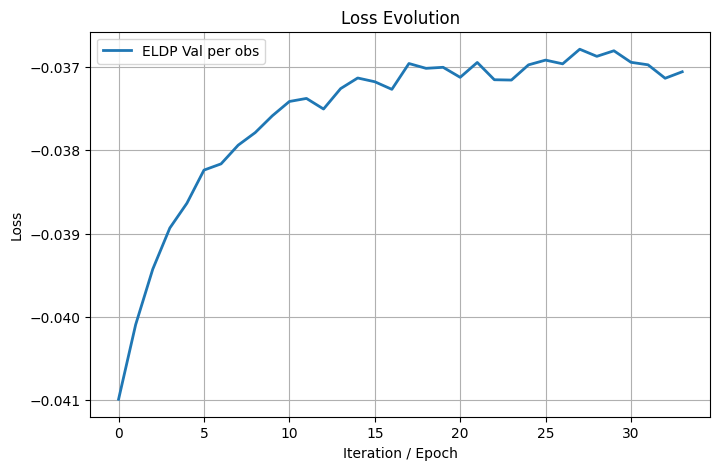

In [11]:
elbo= output['loss_history']
#loss_history = output['ll_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(val_loss, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0269
KLD GTM      Train Data:  0.0075
KLD Gaussian Train Data:  0.1104
KLD Copula   Train Data:  -0.0001

KLD BGTM      Test  Data:  0.0336
KLD GTM      Test  Data:  0.0105
KLD Gaussian Test  Data:  0.1142
KLD Copula   Test  Data:  0.0072


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [15]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

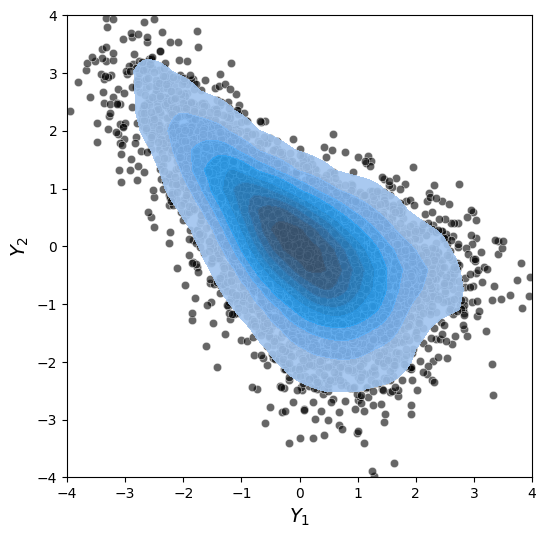

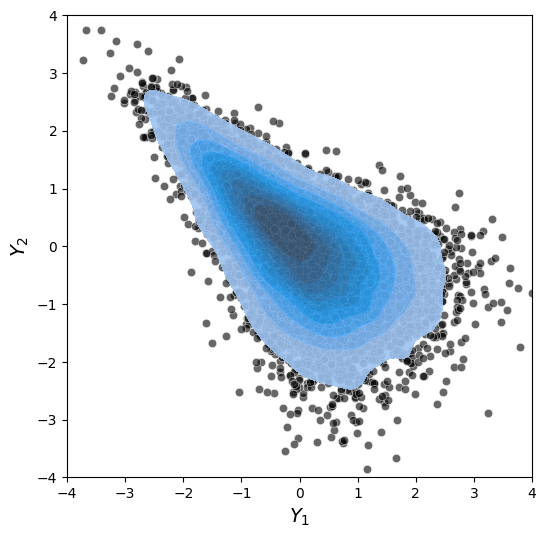

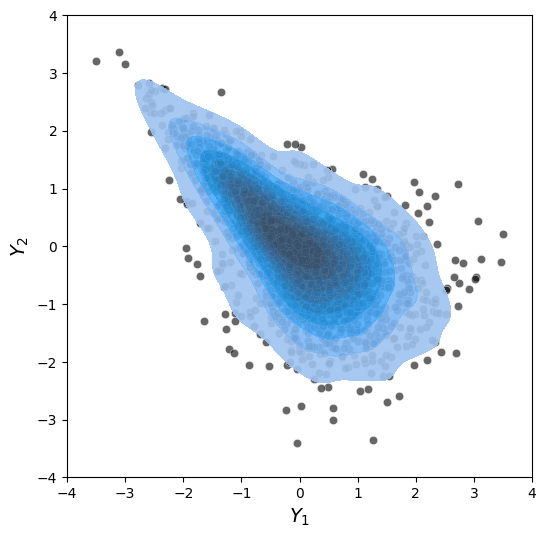

In [16]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [17]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [18]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


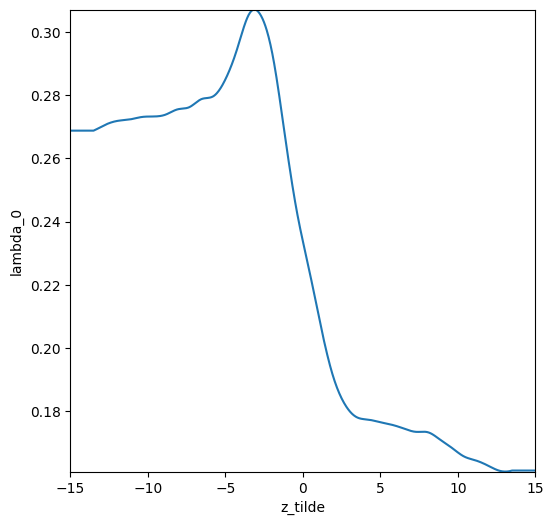

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


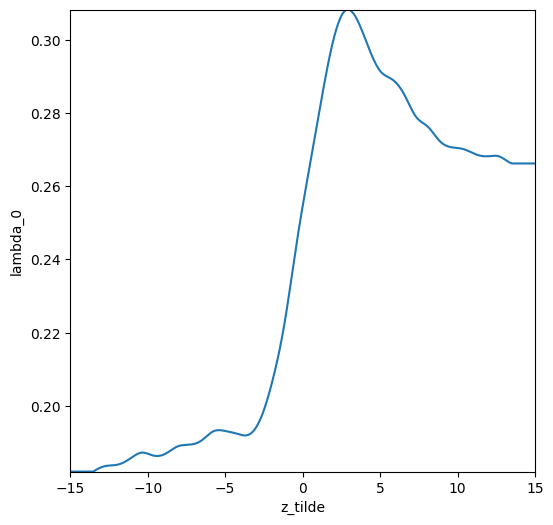

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


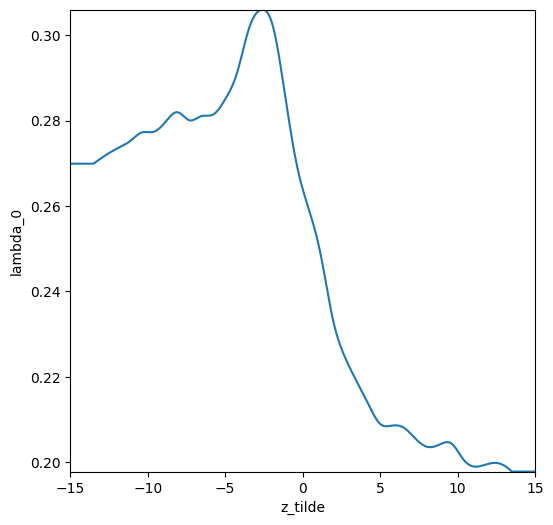

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)